In [2]:
%matplotlib notebook 
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



The goal of this project is to translate data (observed or reconstructed) into a Bayesian likelihood for equilbrium climate sensitivity (ECS), which can then be combined with a prior of one's choice to obtain a probability distribution function.  This requires two things: 1) accurate measurements of temperature change, ocean heat uptake (for transient climate states), and radiative forcing and 2) a model that relates these things to climate sensitivity.  Here, we show that the likelihood depends strongly on the model chosen.

# Estimating ECS from recent transient observations

We assume a simple energy balance model of the climate system, where an external forcing $\Delta F$ leads to a radiative response and an energy imbalance at the top of the atmosphere
$$\Delta F = \lambda \Delta T + \Delta Q$$
The quantity $\lambda$ represents the climate feedback and here, is assumed to be constant in time (we'll revisit this likely flawed assumption later).  

Equilibrium climate sensitivity $S$ is defined as the temperature change at equilibrium in response to a doubling of CO$_2$.  By definition, at equilibrium we have $\Delta Q =0$ and 
$$S = \frac{F_{2\times CO_2} }{\lambda}$$

If (and this is a big if) the feedbacks are constant in time, then the estimated sensitivity from historical observations 
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
is equal to the equilibrium sensitivity ($S=S_{hist}$).



We have observations of the temperature change $\Delta T$ and the rate of ocean heat uptake $\Delta Q$ (roughly equivalent to the TOA imbalance because the land heat capacity is negligible).  We can estimate the radiative forcing $\Delta F$ from inventories of CO$_2$ emissons and aerosol burden.  The uncertainites in these quantities are (initially) assumed to be Gaussian).


In [13]:
nsamp=1000 #change as needed
dT = np.random.normal(loc=1.0,scale=0.14/1.64,size=nsamp)
dQ = np.random.normal(0.60,0.3/1.64,size=nsamp)

<IPython.core.display.Javascript object>


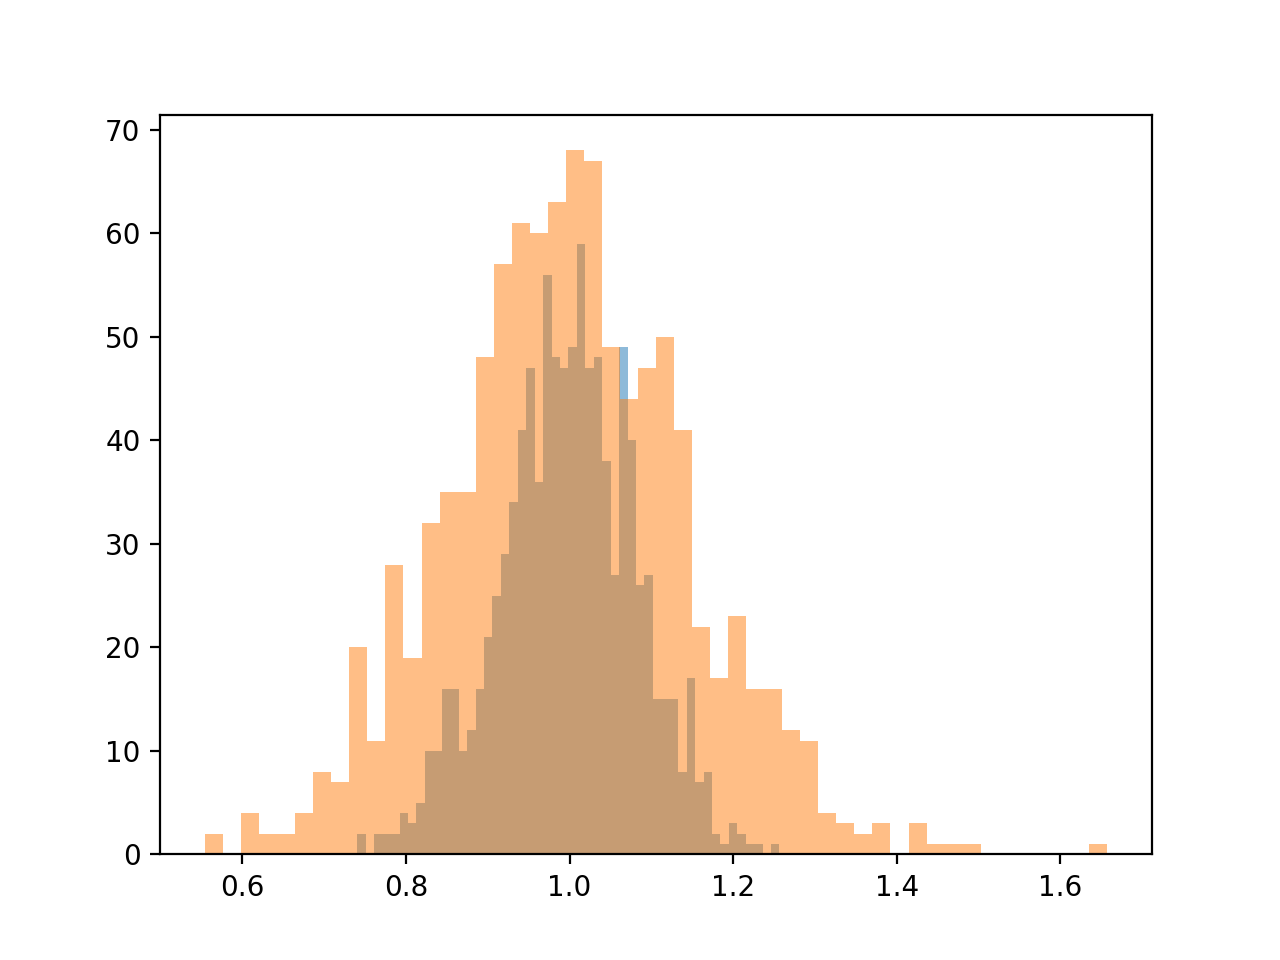

In [14]:
#Test for dT: inflate uncertainty in dT with uncertainty in F2x (assume uncorrelated)
F2x=3.7
F2x_error=np.random.normal(F2x,0.74/1.64,size=nsamp)

plt.figure()
tmp=plt.hist(dT,50,alpha=.5)
tmp=plt.hist(dT*F2x_error/F2x,50,alpha=.5)
dT_with_error=dT*F2x_error/F2x

In [15]:
f=open("hist_forc_out.txt")
test=f.readlines()
f.close()

dF_CO2=float(test[-1].split(":")[-1])
rest=np.array(test[:-1])
baselines=rest[::5]
recents=rest[1::5]
unc_pos=rest[2::5]
unc_neg=rest[3::5]
other_forcings=[x.split("baseline")[0] for x in baselines]
forcing_dict={}
for i in range(len(other_forcings)):
    key=other_forcings[i]
    forcing_dict[key]={}
    devs=np.random.normal(0,1.0,size=nsamp)
    devscaled=np.zeros_like(devs)
    sigma_pos=float(unc_pos[i].split(":")[-1])
    forcing_dict[key]["sigma_pos"]=sigma_pos
    devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*sigma_pos

    sigma_neg=float(unc_neg[i].split(":")[-1])
    forcing_dict[key]["sigma_neg"]=sigma_neg
    devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*sigma_neg
    
    baseline=float(baselines[i].split(":")[-1])
    forcing_dict[key]["baseline"]=baseline
    
    recent=float(recents[i].split(":")[-1])
    forcing_dict[key]["recent"]=recent
    forcing_dict[key]["deviations"] = (recent-baseline)*(1+devscaled)
    
    
    
    

def generate_dF():
    all_forcings=np.zeros((len(other_forcings),nsamp))
    i=0
    for key in other_forcings:
        devs=np.random.normal(0,1.0,size=nsamp)
        devscaled=np.zeros_like(devs)
        devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*forcing_dict[key]["sigma_pos"]
        devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*forcing_dict[key]["sigma_neg"]
        
        all_forcings[i]= (forcing_dict[key]["recent"]-forcing_dict[key]["baseline"])*(1+devscaled)
        i+=1
    return np.sum(all_forcings,axis=0)

Now, take samples of F and $F_{2\times CO_2}$

<IPython.core.display.Javascript object>


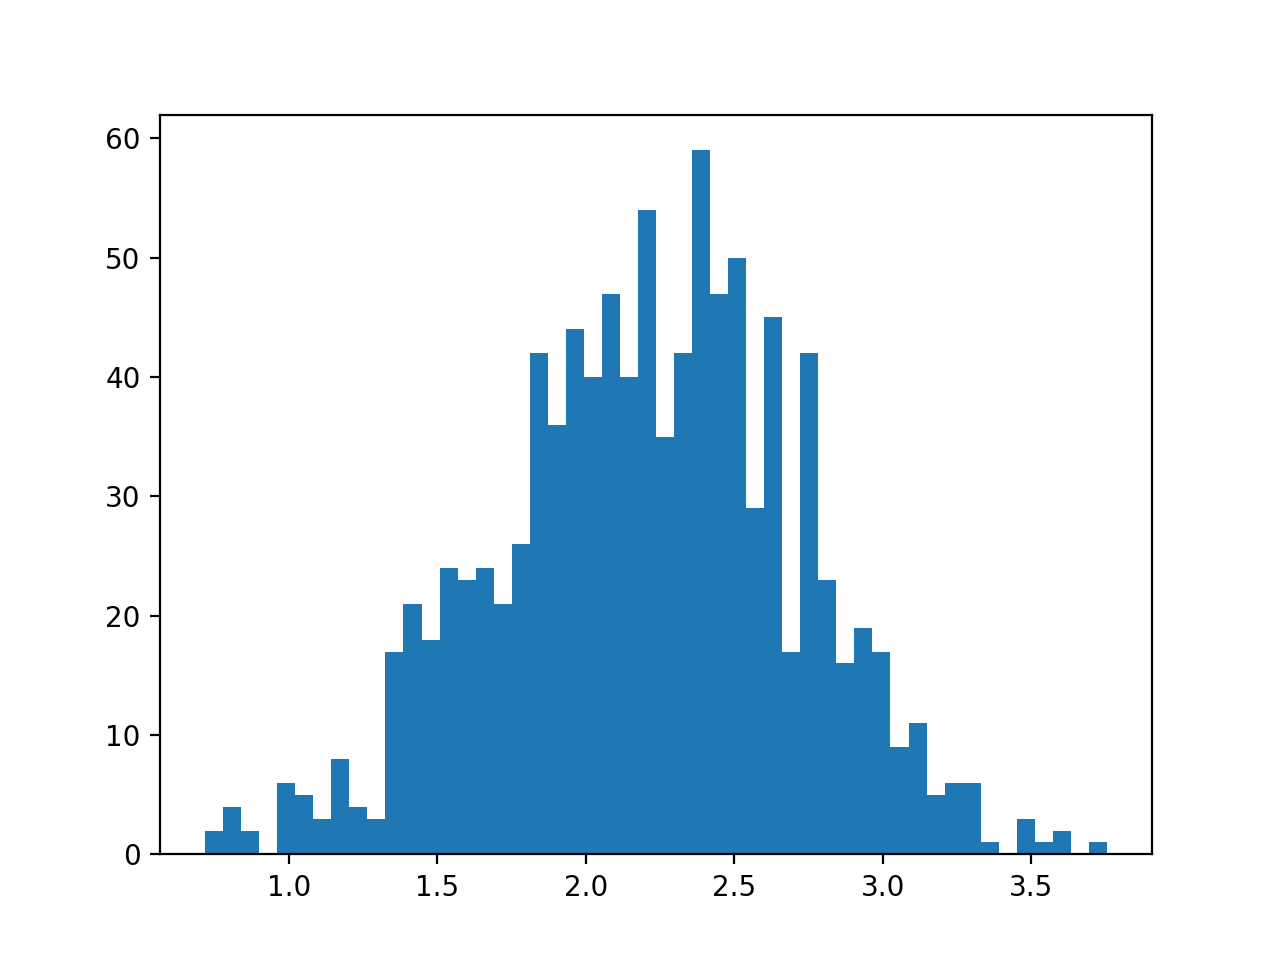

In [16]:
plt.figure()
dF=F2x_error/F2x * dF_CO2 + generate_dF()
ntest,binstest,patchestest=plt.hist(dF,50)

In [17]:
simple_model=F2x*dT_with_error/(dF-dQ)
ECS_best_guess=np.median(simple_model)
print("Best guess ECS = "+str(ECS_best_guess))


Best guess ECS = 2.2889165627483594


Collate into a single array:

x=$\Delta F = \Delta F_{CO2} \times \frac{F_{2xCO2}}{3.7} +\Delta F_{other}$

y=$\Delta Q$

z=$\Delta T$

In [18]:
values = np.zeros((3,nsamp))
values[2]=dT_with_error
values[0]=dF
values[1]=dQ

Now calculate a kernel density estimate from these samples

In [19]:
kde = stats.gaussian_kde(values)

Evaluate the kernel density at the samples in order to plot the 3D joint probability distribution for the observations:

<IPython.core.display.Javascript object>


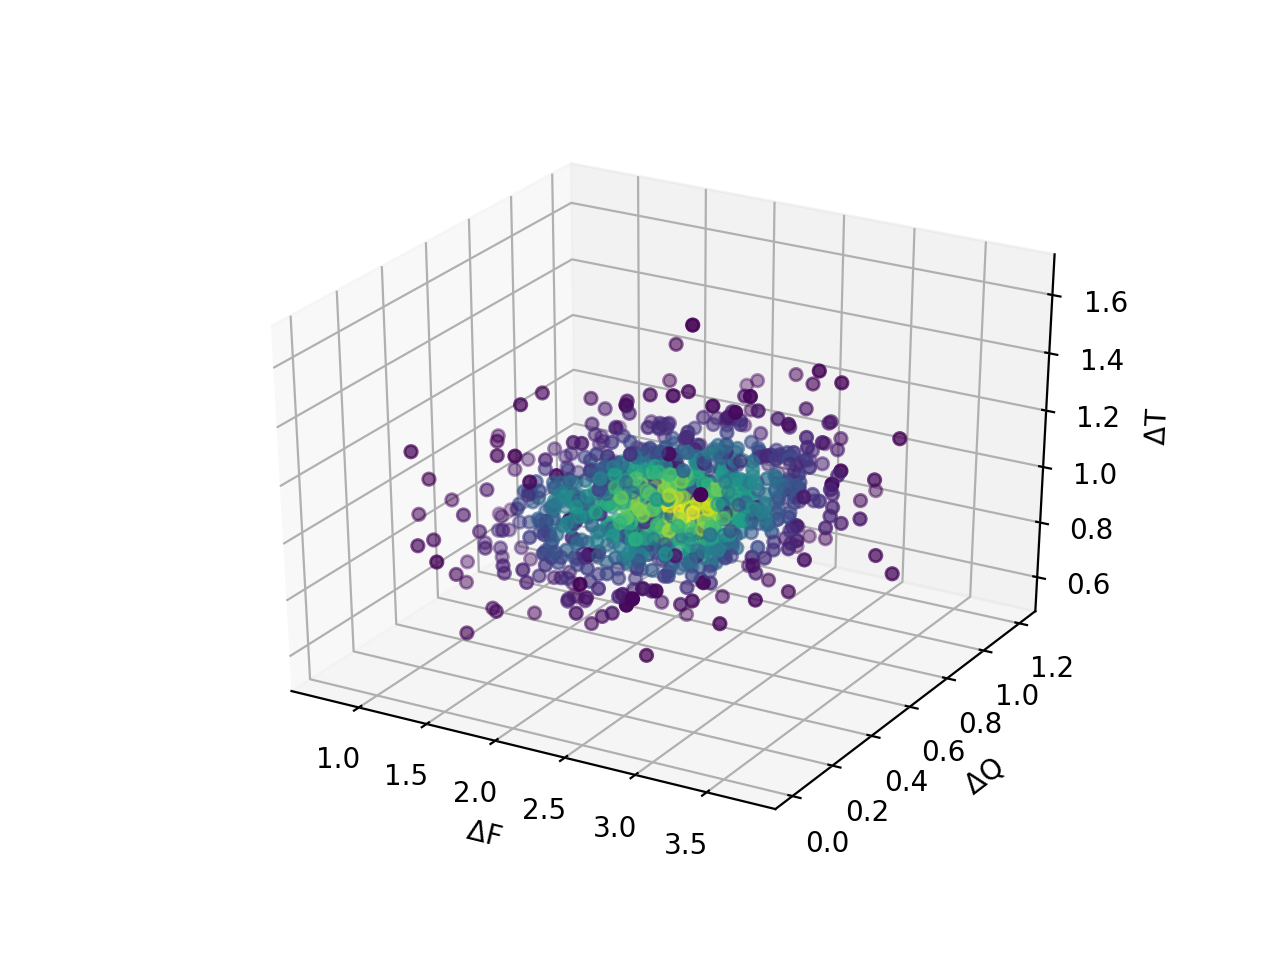

Text(0.5, 0, '$\\Delta$T')

In [20]:
density = kde(values)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(values[0], values[1], values[2], c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

If $S_{hist}$ is simply related to these quantities through
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
then each value of $S_{hist}$ uniquely defines a plane in $(\Delta F, \Delta Q, \Delta T)$ space.


In [21]:
%%capture
def plot_plane(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/F2x*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))
def plot_plane_F2x_uncertainty(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/dF2xCO2_dist*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))

The value of $S_{hist}$ determines the steepness of the plane.  If $S_{hist}=1$, the plane slices through the bottom of the 3D distribution.  If $S_{hist}=5$, the plane grazes the top.  But if $S_{hist}=1.5$, the plane intersects the densest area.  

<IPython.core.display.Javascript object>


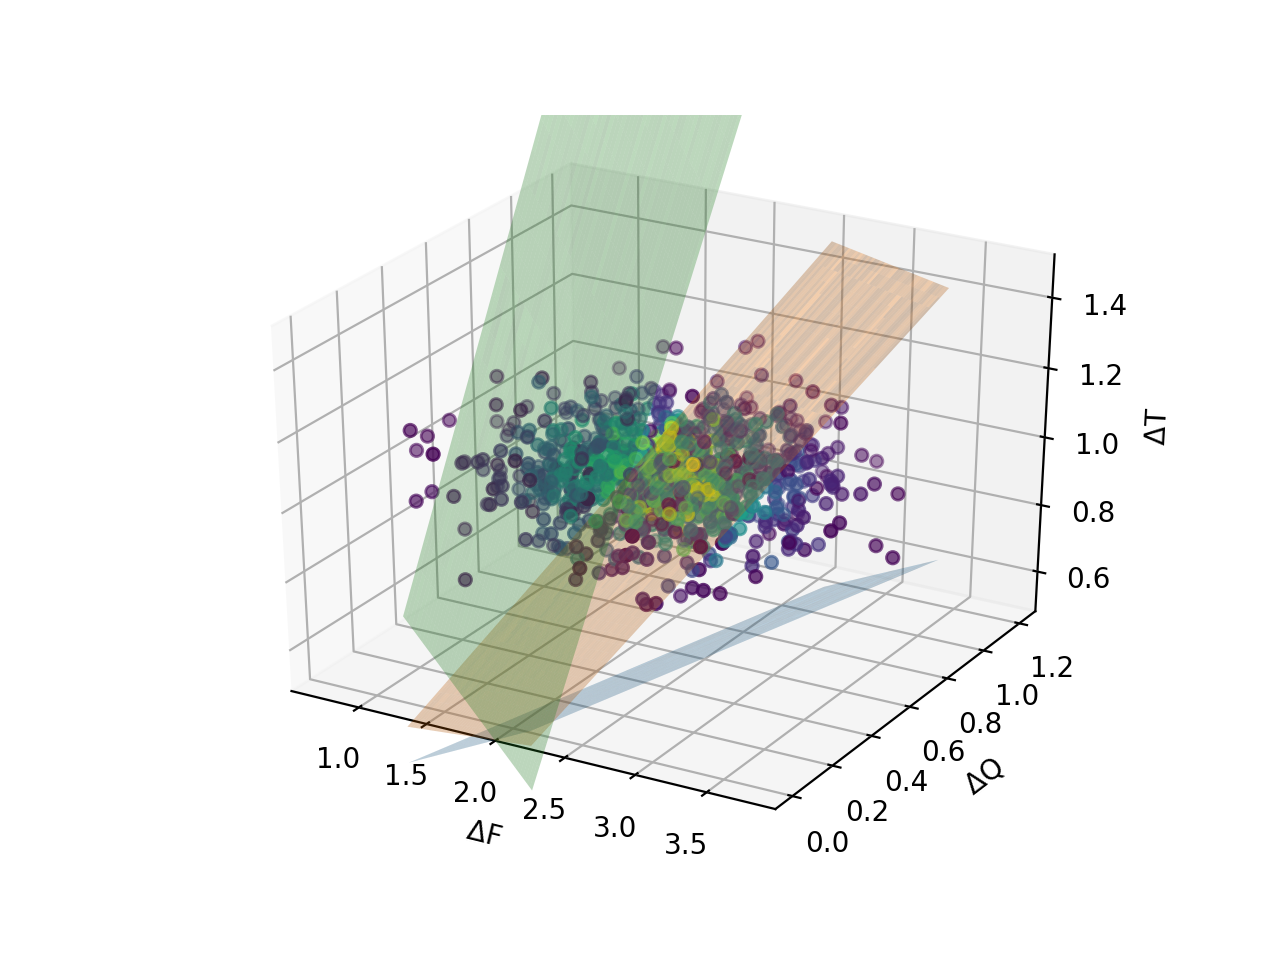

(0.5, 1.5)

In [22]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')
plot_plane(1,ax)
plot_plane(2,ax)
#plot_plane_F2x_uncertainty(1.9,ax)

plot_plane(5,ax)
ax.set_zlim(.5,1.5)


The likelihood of a particular $S_{hist}$ is the area of the intersection of the plane defined by $S_{hist}$ and the 3D kernel density.  Note that here, we're not $sampling$ values of $\Delta F$ or $\Delta Q$, we're just using them to define the plane.  We can then calculate the likelihood function by sweeping through different values of $S_{hist}$:

In [23]:
likelihood = []
Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
Qs = np.linspace(.3,.9,nsamp)
Shist_possibilities = np.linspace(.1,5,num=100)
for Shist in Shist_possibilities:
    #the plane is given by
    #Ts = Shist * (Fs-Qs)/dF2xCO2_dist
    Ts=Shist*(Fs-Qs)/F2x
    #now evaluate the kernel density on the plane using kde
    Svals=np.vstack((Fs,Qs,Ts))
    likelihood += [np.sum(kde(Svals))]

Now plot the likelihood of different values of $S_{hist}$

<IPython.core.display.Javascript object>


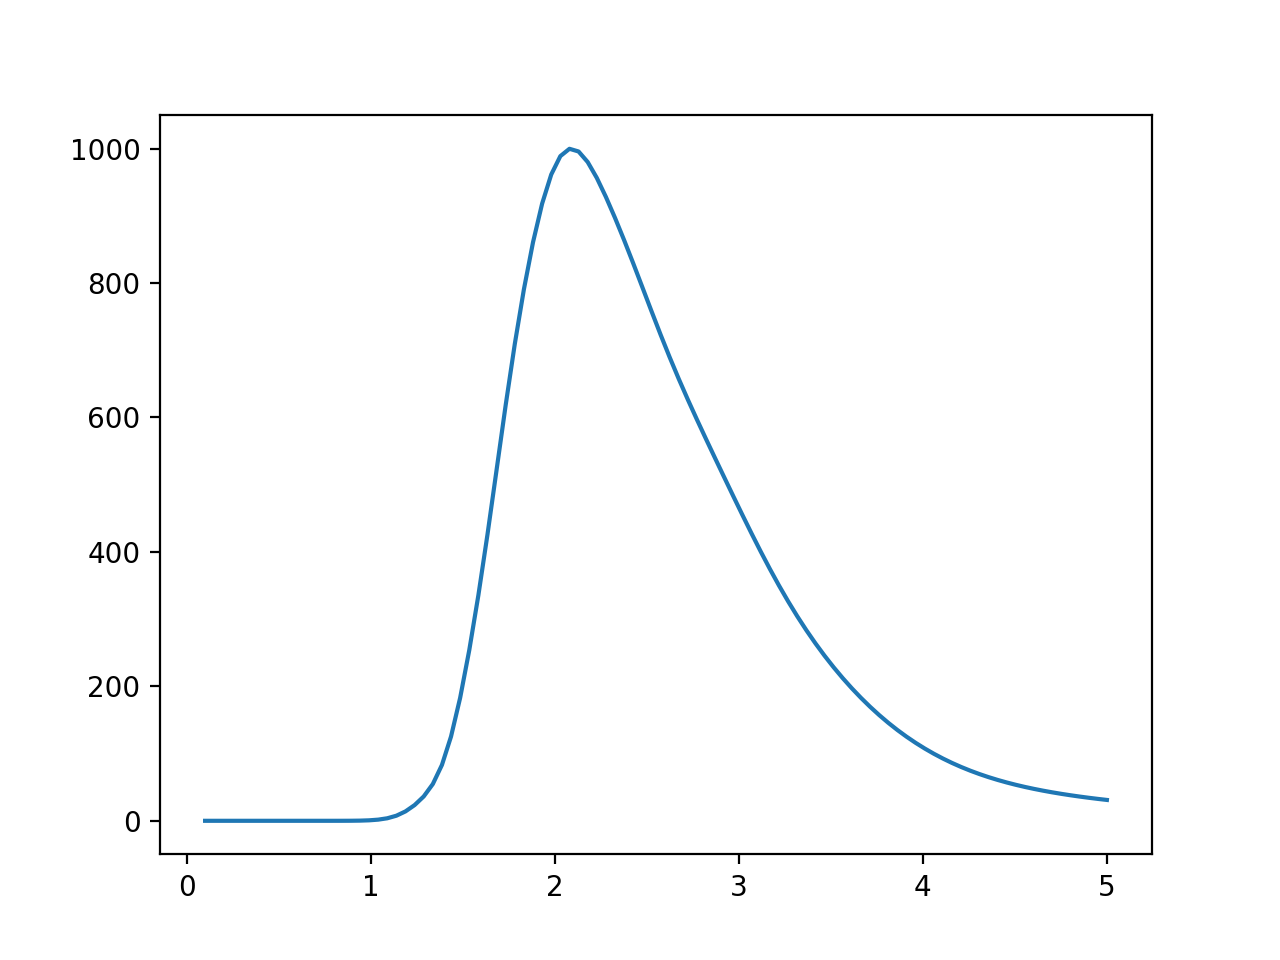

In [24]:
plt.figure()
plt.plot(Shist_possibilities,likelihood)

In [25]:
print("The most likely value of S_hist is "+ str(Shist_possibilities[np.argmax(likelihood)]))

The most likely value of S_hist is 2.07979797979798


What if the feedbacks $\lambda$ are not constant with time ($\lambda=\lambda(t)$)?  This can be parametrized (but is this the best way to do it?) by incorporating an ocean heat efficacy term:
$$\Delta F = \lambda \Delta T + \epsilon\Delta Q$$
or a forcing efficacy term:
$$\eta \Delta F = \lambda \Delta T + \Delta Q$$
These have the effect of tilting the plane in the $\Delta Q$ or $\Delta F$ directions.

In [26]:
%%capture
def plot_plane_efficacy(Shist,epsilon,forcingefficacy=1.,ax=plt.gca(),**kwargs):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/F2x*(forcingefficacy*xx-epsilon*yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist),**kwargs)

<IPython.core.display.Javascript object>


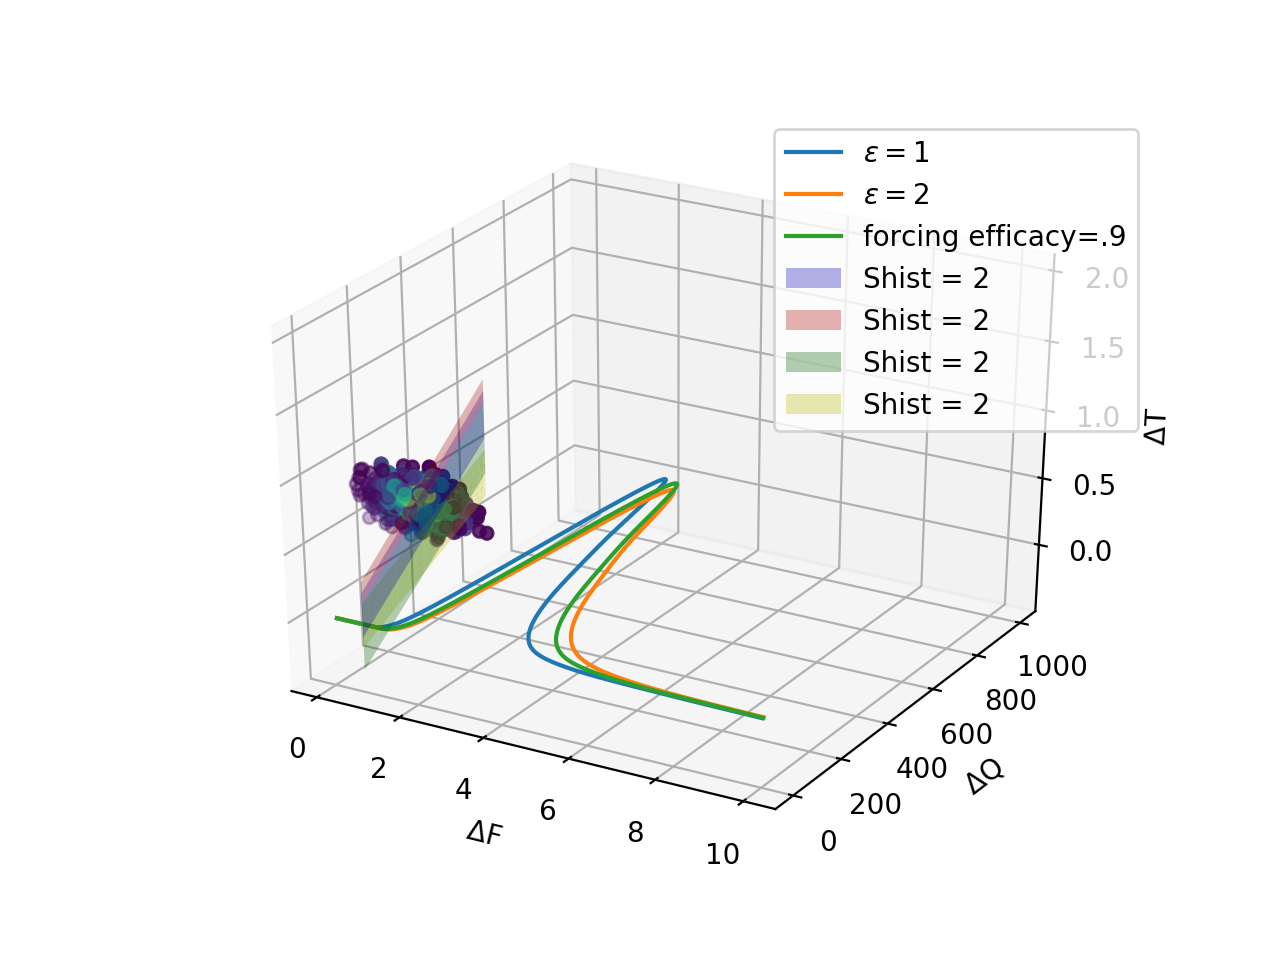

In [27]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

plot_plane_efficacy(2,1,ax=ax,color="blue")
plot_plane_efficacy(2,.5,ax=ax,color="red")
plot_plane_efficacy(2,1.5,ax=ax,color="green")
plot_plane_efficacy(2,1,forcingefficacy=.8,ax=ax,color="yellow")



In [28]:
%%capture
def plot_historical_likelihood(epsilon,forcingefficacy=1,**kwargs):
    likelihood = []
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    Shist_possibilities = np.linspace(.1,10,num=nsamp)
    for Shist in Shist_possibilities:
        #the plane is given by
        #Ts = Shist * (Fs-Qs)/dF2xCO2_dist
        Ts=Shist*(forcingefficacy*Fs-epsilon*Qs)/F2x
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Fs,Qs,Ts))
        likelihood += [np.sum(kde(Svals))]
    plt.plot(Shist_possibilities,likelihood,**kwargs)

<IPython.core.display.Javascript object>


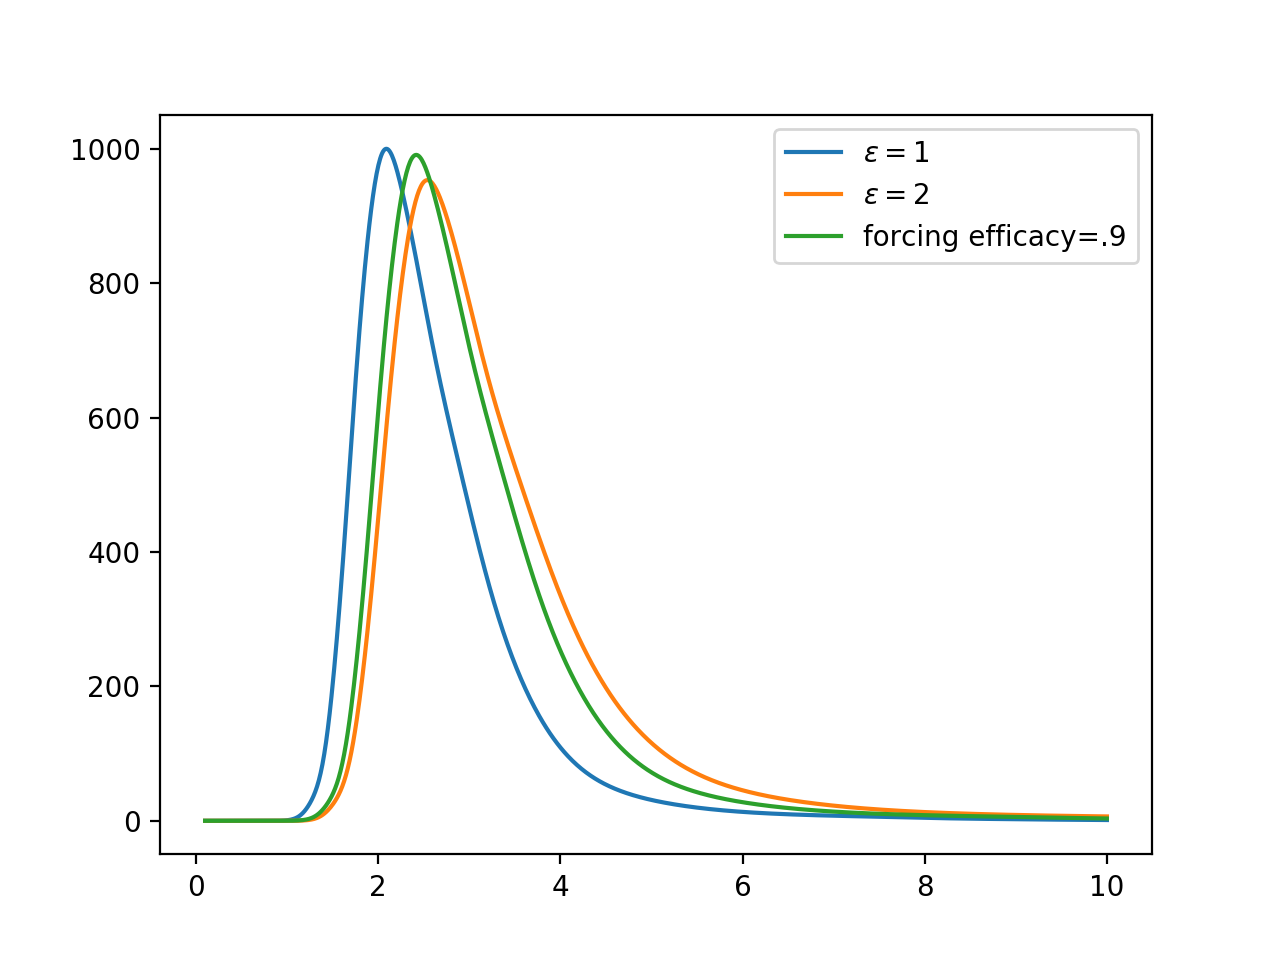

In [30]:
plt.figure()
plot_historical_likelihood(1,label=r'$\epsilon=1$')
plot_historical_likelihood(1.5,label=r'$\epsilon=2$')
plot_historical_likelihood(1,forcingefficacy=0.9,label='forcing efficacy=.9')
plt.legend()

# Last Glacial Maximum

We assume the climate is in equilibrium ($\Delta Q = 0$.)  If there is no state dependence, then we can write 
$$S=\frac{F_{2\times CO_2} \Delta T}{\Delta F}.$$

In [ ]:
%%capture
def plot_line(S):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*F2x/S)
    
    

However, it is possible that the feedbacks may be stronger or weaker in a cold climate.  To reflect this, we can expand 
$$\Delta F = \frac{\partial F}{\partial T}\Delta T + \frac{1}{2}\frac{\partial^2 F}{\partial T^2} \Delta T^2$$
and set $\alpha=\frac{1}{2}\frac{\partial^2 F}{\partial T^2}$.  In this case, we have 
$$\Delta T=\frac{\Delta F}{\lambda + \alpha \Delta T}$$

In [ ]:
%%capture
def plot_complex_line(S,alpha,ax=plt.gca(),**kwargs):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*(F2x/S+alpha*Ts),**kwargs)
    

From paleo: We can reconstruct carbon dioxide (and thus forcing) and temperature.  
Last glacial to interglacial global mean temperature estimates range from 3K to 7K, so we'll take 
$$\Delta T_{LGM} = N(5,1). $$
Let's also assume that forcing is 
$$\Delta F_{LGM} = N(-8.8,2.0)$$
Once again, we can calculate the kernel density. For a given ECS and state dependence $\alpha$, this defines a curve in ($\Delta T, \Delta F$) space.   

In [ ]:
dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)
dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
values_LGM = np.zeros((2,nsamp))
values_LGM[0]=dT_LGM
values_LGM[1]=dF_LGM
kde_LGM = stats.gaussian_kde(values_LGM)
density_LGM = kde_LGM(values_LGM)
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_complex_line(3,0,ax=ax,label="ECS=3, no state dep")

#plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(4,-.1,label=r"ECS=4, $\alpha=-0.1$")
plot_complex_line(4,0,label=r"ECS=4, $\alpha=0$")
plt.legend()

In [ ]:
def get_LGM_likelihood(alpha,plot=True,print_max_likelihood=False):
    likelihood_LGM = []

    Ts = np.linspace(-10,0,nsamp)
    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Fs=Ts*(F2x/S+alpha*Ts)
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Ts,Fs))
        likelihood_LGM += [np.sum(kde_LGM(Svals))]
    if plot:
        plt.plot(S_possibilities,likelihood_LGM,label=r"$\alpha=$"+str(alpha))
        plt.xlabel("S")
        plt.ylabel("Likelihood")
    if print_max_likelihood:
        print("Max likelihood is "+str(S_possibilities[np.argmax(likelihood_LGM)]))
    else:
        return likelihood_LGM


Once again, we can calculate the likelihood for different values of $S$.  Note that even for small state dependences, the right-hand tail gets much fatter.

In [ ]:
get_LGM_likelihood(0.)

get_LGM_likelihood(alpha=-0.1)
get_LGM_likelihood(alpha=-0.05)
plt.legend()

But there's a distinction between state dependence (where "state" is defined as the global mean temperature) and dependence on the specific forcing that's causing that temperature change.  In the LGM, the forcing comes from both CO2 and from NH ice sheets, with small contributions from vegetation and dust.  It is not unreasonable to suspect that shortwave forcing concentrated mainly in the NH might be less effective at changing the global mean temperature than well-mixed greenhouse gases.

In [ ]:
%%capture
def plot_forcing_efficacy(S,epsilon,ax=plt.gca(),beta=-0.6,**kwargs):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,F2x/epsilon*(Ts/S-beta)+beta*F2x,**kwargs)



In [ ]:

dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)
dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
values_LGM = np.zeros((2,nsamp))
values_LGM[0]=dT_LGM
values_LGM[1]=dF_LGM
kde_LGM = stats.gaussian_kde(values_LGM)
density_LGM = kde_LGM(values_LGM)
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_forcing_efficacy(3,1)
plot_forcing_efficacy(3,.6)


In [ ]:
def get_LGM_efficacy_likelihood(epsilon,plot=True,beta=-0.6,print_max_likelihood=False):
    likelihood_LGM = []

    Ts = np.linspace(-10,0,nsamp)
   
    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the line is given by
        Fice=F2x/epsilon*(Ts/S-beta)
        Fs=Fice+beta*F2x
        
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Ts,Fs))
        likelihood_LGM += [np.sum(kde_LGM(Svals))]
    if print_max_likelihood:
        print("Max likelihood is "+str(S_possibilities[np.argmax(likelihood_LGM)]))
    if plot:
        plt.plot(S_possibilities,likelihood_LGM,label=r"$\epsilon=$"+str(epsilon))
        plt.xlabel("S")
        plt.ylabel("Likelihood")
    else:
        return likelihood_LGM
    
get_LGM_efficacy_likelihood(.9)
get_LGM_efficacy_likelihood(.6)

plt.legend()

Does it really matter whether the "state dependence" comes from the reduced temperature or the efficacy of the ice sheet forcings?  Let's see what happens when we choose values of forcing efficacy $\epsilon$ and state dependence $\alpha$ that should both lead to a most likely value of ECS around 3K:

In [ ]:
Fav=np.average(dF_LGM)
Tav=np.average(dT_LGM)
alpha_S=lambda S:(Fav-F2x/S*Tav)/(Tav**2)
print(alpha_S(3))
Fco2_LGM=-0.6*F2x
Fice_av=Fav-Fco2_LGM
epsilon_S=lambda S:(F2x/S * Tav - Fco2_LGM)/Fice_av
print(epsilon_S(3))


In [ ]:
get_LGM_efficacy_likelihood(epsilon_S(3),print_max_likelihood=True)
get_LGM_likelihood(alpha_S(3),print_max_likelihood=True)
plt.legend()
plt.axvline(3)

In [ ]:
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_complex_line(2,alpha_S(3),ax=ax,label="ECS=2")

#plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(3,alpha_S(3),label=r"ECS=3, $\alpha=-0.1$")


plt.legend()
plt.axvline(Tav)
plt.axhline(Fav)

print(Tav*(F2x/3+alpha_S(3)*Tav))
print(Fav)

# Inferring ECS from the Pliocene

The mid-Pliocene , which occured 3.3-3.0 MYa, is the most recent analogue for a hot, high-CO$_2$ climate.  We take 
$$\Delta T_{pliocene} = N(3,1)$$
and 
$$\Delta CO2_{pliocene} = N(375,25)$$

In [ ]:
%%capture
def plot_line_pliocene(S,ESS,ax=plt.gca()):
    Fs = np.linspace(0,4,num=nsamp)
    
    plt.plot(Fs,(S/F2x)*Fs*(1+ESS))


In [ ]:
dT_pliocene = np.random.normal(loc=3.0,scale=1.0,size=nsamp)
dCO2_pliocene=np.random.normal(375.,scale=25.0,size=nsamp)
dFCO2_pliocene=np.log(dCO2_pliocene/280.)/np.log(2.0)*F2x
dF_pliocene=dFCO2_pliocene*(1+np.random.normal(.4,scale=0.1,size=nsamp))
values_pliocene = np.zeros((2,nsamp))
values_pliocene[1]=dT_pliocene
values_pliocene[0]=dF_pliocene
kde_pliocene = stats.gaussian_kde(values_pliocene)
density_pliocene = kde_pliocene(values_pliocene)
plt.scatter(dF_pliocene,dT_pliocene,c=density_pliocene)
plot_line_pliocene(4,0)
plot_line_pliocene(4,.5)
plot_line_pliocene(3,.5)

In [ ]:
np.max(dF_pliocene)

$S_{pliocene} = \frac{\Delta T_{pliocene} F_{2x}}{\Delta F_{CO2}(1+ESS)}$

In [ ]:
%%capture
def get_pliocene_likelihood(ESS,plot=True):
    likelihood_pliocene = []
    Fs = np.linspace(0,5,nsamp)

    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Ts =(S/F2x)*Fs*(1+ESS)
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Fs,Ts))
        likelihood_pliocene += [np.sum(kde_pliocene(Svals))/np.sum(density_pliocene)]
    if plot:
        plt.plot(S_possibilities,likelihood_pliocene,label="fESS ="+str(ESS))
    else:
        return likelihood_pliocene
    

In [ ]:
get_pliocene_likelihood(0)
get_pliocene_likelihood(.5)
plt.legend()

Let $\lambda = \lambda(\bar{T}+T'(r))$ where $\bar{T(r)} $ is the global mean temperature and $T'(r)$ the spatial anomaly pattern.  Then
$$\frac{d \lambda}{dt}=\frac{\partial \lambda}{\partial \bar{T}}  \frac{d\bar{T}}{dt} +\frac{\partial \lambda}{\partial T'}  \frac{d T'}{dt} = 2\alpha \frac{d\bar{T}}{dt} +\kappa  \frac{d T'}{dt} $$
The first term represents the state dependence $\alpha \equiv \frac{\partial^2 F}{\partial \bar{T}^2}$ multiplied by the global mean temperature, which changes with time.  The second term represents the pattern effect; $\kappa$ is the radiative kernel, assumed constant in time.

Assume exponentially decaying $T'(t)$.  Assume linear increase in T.
$$\frac{d \lambda}{dt}= C + K*\exp\left(-t/\tau\right)$$

 ## Efficacies And State Dependence From Hansen et al 2005

In [ ]:
CO2 = [0.125,0.5,1.25,1.5,2.,4.,8.]
Es=[0.95,0.96,0.98,0.95,1.,1.03,1.02,1.02]
Esreg=[0.98,0.99,1,1.03,1.13,1.07,1.08,1.13]
TgFg=1.1/2.39

In [ ]:
Ts=[-4.56,-3.32,-1.78,0.58,1.1,1.96,4.06,7.02]
Fs=[-10.3,-7.44,-3.91,1.32,2.38,4.11,8.58,13.97]
Fa=[-10.94,-7.74,-4.07,1.3,2.39,4.12,8.53,13.53]
Fi=[-12.68,-8.88,-4.61,1.44,2.64,4.52,9.27,14.65]

In [ ]:
plt.plot(Ts,Fs,"o-",label="ERF")
plt.plot(Ts,Fa,"d:",label="ARF")
plt.plot(Ts,Fi,"s--",label="IRF")
plt.xlabel(r"$\Delta T$")
plt.ylabel(r"$\Delta F$")
plt.legend()

The main difference is in the stratosphere: stratospheric adjustments are larger in a cold climate

In [ ]:
alpha_erf=np.polyfit(Ts,Fs,2)[0]
alpha_arf=np.polyfit(Ts,Fa,2)[0]
alpha_irf=np.polyfit(Ts,Fi,2)[0]

In [ ]:
alpha_erf

In [ ]:
get_LGM_likelihood(alpha=alpha_erf,print_max_likelihood=True)
get_LGM_likelihood(alpha=alpha_irf,print_max_likelihood=True)
get_LGM_likelihood(alpha=0,print_max_likelihood=True)
#lgm_giss=get_LGM_likelihood(alpha=alpha_erf,plot=False)
#lgm_0=get_LGM_likelihood(alpha=0,plot=False)
#print(np.linspace(.1,10,num=nsamp)[np.argmax(lgm_giss)])
#np.linspace(.1,10,num=nsamp)[np.argmax(lgm_0)]
plt.legend()

In [ ]:
Fi_solar=[-45.28,-22.64,-11.32,-4.53,4.53,11.32]
Fa_solar=[-45.87,-22.94,-11.47,-4.59,4.59,11.47]
Fs_solar=[-45.91,-22.69,-11.3,-4.51,4.52,11.11]
Ts_solar=[-26.85,-9.51,-4.53,-1.93,2.07,5.31]

In [ ]:
plt.plot(Ts_solar,Fs_solar,"o-",label="ERF")
plt.plot(Ts_solar,Fa_solar,"d:",label="ARF")
plt.plot(Ts_solar,Fi_solar,"s--",label="IRF")
plt.legend()

In [ ]:
alpha_solar=np.polyfit(Ts_solar,Fs_solar,2)[0]